# Descrição

Nessa tarefa você vai estender sua implementação da tarefa passada para considerar múltiplas variáveis. Você pode estender a versão vetorizada implementada neste notebook para regressão simples. 

- Rode o algoritmo nesses dados, onde as linhas representam as notas de alunos de computação de alunos da UFCG em algumas disciplinas do primeiro período. A última coluna é a variável alvo representando o CRA final depois de concluir o curso. As outras colunas são algumas disciplinas do primeiro período. O pressuposto aqui é que as notas em disciplinas no primeiro período ajudam a explicar o CRA final dos alunos de computação.

- Compare o valor dos coeficientes estimados pelo seu algoritmo com o valor dos coeficientes da regressão linear do scikit learn para testar se o seu algoritmo está funcionando corretamente.

A entrega deve ser o link no seu github para o notebook Jupyter com código python e texto explicativo quando necessário. De preferência, crie um repositório na sua conta do github e envie o link do html do notebook.

# Import Libraries

In [128]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(style="ticks")

# Load Data

In [129]:
grades_df = pd.read_csv('../data/grades.csv')
grades_df.rename(index=str, columns={'Cálculo1': 'Calc1', 'Cálculo2': 'Calc2'}, inplace=True)
grades_df.head()

,Calc1,LPT,P1,IC,Calc2,cra
0,8.7,10.0,9.0,9.1,8.4,8.477647
1,7.0,7.0,7.7,7.0,6.2,6.851724
2,8.6,9.8,7.9,9.6,8.7,9.090588
3,7.8,8.3,6.8,8.2,8.0,7.283516
4,5.2,9.3,5.0,8.5,5.0,7.205747


### Check Dataset Size

In [130]:
grades_df.shape

(88, 6)

In [131]:
grades_df_aux = pd.DataFrame(grades_df)
grades_df_aux['Status'] = grades_df_aux.cra.apply(lambda x:  "Success" if x >= 7 else "Fail")
grades_df_aux.head()

,Calc1,LPT,P1,IC,Calc2,cra,Status
0,8.7,10.0,9.0,9.1,8.4,8.477647,Success
1,7.0,7.0,7.7,7.0,6.2,6.851724,Fail
2,8.6,9.8,7.9,9.6,8.7,9.090588,Success
3,7.8,8.3,6.8,8.2,8.0,7.283516,Success
4,5.2,9.3,5.0,8.5,5.0,7.205747,Success


### Plot Scatterplots

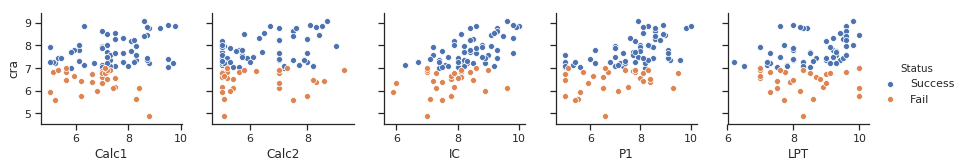

In [132]:
sns.pairplot(grades_df_aux, hue="Status", y_vars=['cra'], x_vars=['Calc1', 'Calc2','IC','P1','LPT'])

## Define Functions

### Compute Mean Squared Error - Vectorized Version

$MSE(\hat{w})=\frac{1}{N}(y-\hat{\mathbf{w}}^T\mathbf{x})^T(y-\hat{\mathbf{w}}^T\mathbf{x})$

In [133]:
def compute_mse_vectorized(w, X, Y):
    res = Y - np.dot(X,w)
    totalError = np.dot(res.T,res)
    return totalError / float(len(Y))

### Função para fazer uma atualização dos parâmetros no Gradiente Descendente:

In [134]:
def step_gradient_vectorized(w_current, X, Y, lr):
    temp1 = np.multiply(-2, X.T)
    temp2 = Y - np.dot(X, w_current)
    grads = np.matmul(temp1, temp2)
        
    new_w = np.array([w_current[i] - lr * grads[i] for i in range(len(grads))])
    
    new_error = compute_mse_vectorized(new_w, X, Y)
    l2_norm = np.linalg.norm(grads, ord=2)  # compute l2-norm
    
    return [new_w, grads, new_error, l2_norm]

### Função para rodar o gradiente descendente vetorizado

In [135]:
def gradient_descent_runner_vectorized(starting_w, X, Y, learning_rate, epsilon, verbose=False, period=1000):
    history = pd.DataFrame(columns=['weights','grads','error','iter','l2_norm'])
    w = starting_w
    grads = np.array([np.inf for feat in range(X.shape[1])])
    i = 0
    while (np.linalg.norm(grads) >= epsilon):
        step_grad = step_gradient_vectorized(w, X, Y, learning_rate)
        w, grads, new_error, l2_norm = step_grad[0], step_grad[1], step_grad[2], step_grad[3]
        
        if verbose and (i % period == 0):
            print("MSE na iteração {0} é de {1}".format(i, new_error))
        
        history = history.append({'weights': w, 'grads': grads, 'error': new_error, 'iter': i, 'l2_norm': l2_norm}, ignore_index=True)
        i+= 1
        
    return history

### Função para fazer o treinamento

In [136]:
%%time

def run():
    X = grades_df.iloc[:, 0:5]
    Y = grades_df.cra[:,np.newaxis]
    init_w = np.zeros((X.shape[1],1))
    
    learning_rate = 1e-5
    epsilon = 1e-1
    
    initial_error = compute_mse_vectorized(init_w, X,Y)
    print("Starting gradient descent at weights = {0}, error = {1}".format(str(init_w), initial_error))
    print("Running...")
    
    history = gradient_descent_runner_vectorized(init_w, X, Y, learning_rate, epsilon, verbose=True)
    
    final_error = compute_mse_vectorized(history.weights.iloc[-1], X,Y)
    
    print("After {0} iterations".format(history.iter.iloc[-1]))
    print("Ending gradient descent at  weights = {0}, error = {1}".format(str(history.weights.iloc[-1]), final_error))
    print("Learning Rate = {}".format(learning_rate))
    
    return history    


h = run()

Starting gradient descent at weights = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]], error = [[54.47995386]]
Running...
MSE na iteração 0 é de [[13.63352979]]
MSE na iteração 1000 é de [[0.43870244]]
MSE na iteração 2000 é de [[0.43328946]]
MSE na iteração 3000 é de [[0.43257927]]
MSE na iteração 4000 é de [[0.43248347]]
MSE na iteração 5000 é de [[0.43247052]]
After 5636 iterations
Ending gradient descent at  weights = [[0.13444624]
 [0.12631814]
 [0.16074068]
 [0.46815686]
 [0.04179104]], error = [[0.43246906]]
Learning Rate = 1e-05
CPU times: user 15.5 s, sys: 12 ms, total: 15.5 s
Wall time: 15.5 s


## Testing with the Scikit-Learn Lib

In [137]:
%%time

X = grades_df.iloc[:, 0:5]
Y = grades_df.cra[:,np.newaxis]

regr = linear_model.LinearRegression()
regr.fit(X, Y)

Y_pred = regr.predict(X)

# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print("Mean squared error: %.4f"
      % mean_squared_error(Y, Y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y, Y_pred))


Coefficients: 
 [[0.10304143 0.0464367  0.16409834 0.38117843 0.02027816]]
Mean squared error: 0.4113
Variance score: 0.42
CPU times: user 5.46 ms, sys: 11 µs, total: 5.47 ms
Wall time: 2.04 ms


### Conclusões

Observando os resultados obtidos com a biblioteca scikit-learn, nós podemos concluir que chegamos em um resultado bastante próximo em termos numéricos considerando tantos os pesos quanto o erro calculado (MSE). Entretanto, em termos de tempo de execução, nossa implementação é bem mais ineficiente.

# Extras

In [138]:
hist_1 = run()

Starting gradient descent at weights = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]], error = [[54.47995386]]
Running...
MSE na iteração 0 é de [[13.63352979]]
MSE na iteração 1000 é de [[0.43870244]]
MSE na iteração 2000 é de [[0.43328946]]
MSE na iteração 3000 é de [[0.43257927]]
MSE na iteração 4000 é de [[0.43248347]]
MSE na iteração 5000 é de [[0.43247052]]
After 5636 iterations
Ending gradient descent at  weights = [[0.13444624]
 [0.12631814]
 [0.16074068]
 [0.46815686]
 [0.04179104]], error = [[0.43246906]]
Learning Rate = 1e-05


## Define Plot Functions

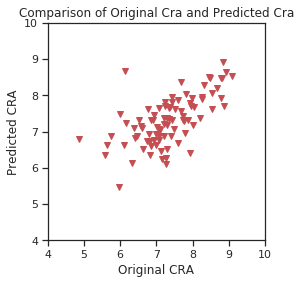

<Figure size 432x288 with 0 Axes>

In [139]:
def _calculate_cra(row, weights):
    return weights[0] * row[0] + \
           weights[1] * row[1] + \
           weights[2] * row[2] + \
           weights[3] * row[3] + \
           weights[4] * row[4]

def plot_predicted_values_vs_orig_values(hist):
    predictions_df = pd.DataFrame(grades_df)
    
    weights = [hist.weights.iloc[-1][i][0] for i in range(0, 5)]
    
    predictions_df['Predicted_Cra'] = predictions_df.apply(lambda row : _calculate_cra(row, weights), axis=1)
    
    plt.plot(predictions_df['cra'], predictions_df['Predicted_Cra'], 'rv') 
    plt.title('Comparison of Original Cra and Predicted Cra') 
    plt.xlabel('Original CRA')
    plt.ylabel('Predicted CRA')
    
    plt.xlim(4, 10)
    plt.ylim(4, 10)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.figure()
    plt.show()

plot_predicted_values_vs_orig_values(hist_1)    

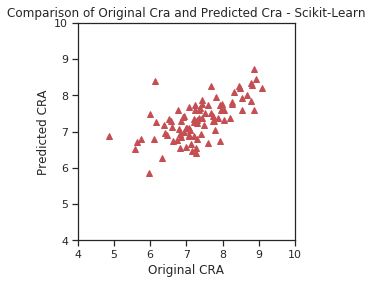

<Figure size 432x288 with 0 Axes>

In [143]:
def plot_predicted_values_from_scikit_lib():
    X = grades_df.iloc[:, 0:5]
    Y = grades_df.cra[:,np.newaxis]
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    Y_pred = regr.predict(X)
    
    plt.plot(Y, Y_pred , 'r^') 
    plt.title('Comparison of Original Cra and Predicted Cra - Scikit-Learn')
    
    plt.xlabel("Original CRA")
    plt.ylabel("Predicted CRA")
    
    plt.xlim(4, 10)
    plt.ylim(4, 10)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.figure()
    plt.show()

plot_predicted_values_from_scikit_lib()    

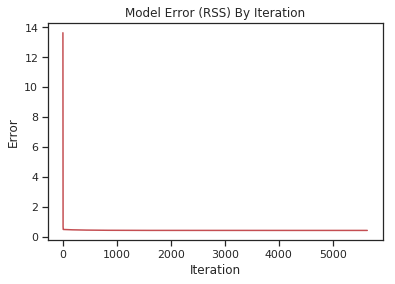

<Figure size 432x288 with 0 Axes>

In [140]:
def plot_model_error_on_training(hist):
    plt.plot(hist['iter'], hist['error'] , 'r', label='Model Error') 
    plt.title('Model Error (RSS) By Iteration')
    
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.figure()

    plt.show()

plot_model_error_on_training(hist_1)